## Title: Urbanization and Biodiversity Loss: Analyzing the Impact on Phoenix, AZ (2017-2020)
###### Author: Joshua Mull
###### Github: https://github.com/llumj/Biodiversity_Intactness_Index_change_in_Maricopa_County

#### About

#### Purpose
This notebook examines the impact of urbanization on biodiversity loss in Phoenix, AZ, from 2017 to 2020. Through data analysis and visualization, it aims to identify areas where biodiversity intactness has been most significantly affected.

#### Highlights
- Temporal Analysis: Comparison of biodiversity intactness index (BII) data between 2017 and 2020.

- Spatial Visualization: Identification and visualization of areas with significant biodiversity loss.

- Impact of Urbanization: Correlation between urban expansion and biodiversity loss.

#### About the Data
The data used in this analysis includes the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog as well as a shapefile for Phoenix Subdivision from the Census.gov website. The Biodiversity Intactness Index (BII) is a measure of how much of a region's natural biodiversity remains intact despite human pressures. It estimates the average abundance of native species in a given area compared to their abundance in undisturbed conditions. The BII is calculated using data on plants, fungi, and animals from ecological studies conducted worldwide

##### References

Microsoft. (n.d.). Iodiversity: Invasive species and ecosystems. Microsoft Planetary Computer. Retrieved from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau. (2022). County subdivisions. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

#### Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import contextily as ryan 
import pandas as pd 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches





from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

#### Import Shapefile 
Use read_csv from geopandas because we are working with 3-Dimensional data. Now that I have a dataframe with subdivisions in AZ, I'll filter the geodatabase for just 'Phoenix' subdivision, then plot to check.

<Axes: >

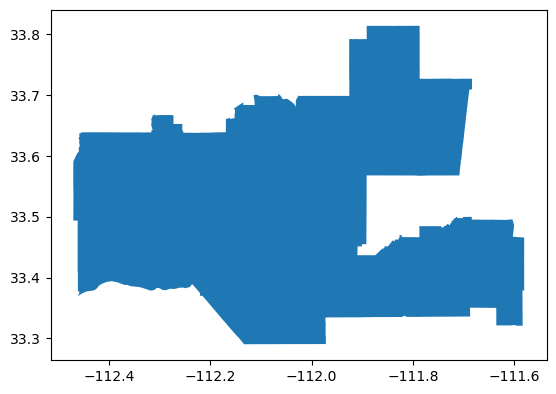

In [2]:
# Import with geopandas 
arizona = gpd.read_file("data/tl_2022_04_cousub.shp")

# Subset to just Phoenix subdivision 
arizona = arizona[arizona.NAME == 'Phoenix']

# Plot to check 
arizona.plot()

#### Access & Catalog Exploration
We use the Client function from the pystac_client package to access the catalog:

In [3]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Let’s check out some of the catalog’s metadata. This can be done with the attributes .title and .description

In [4]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


Use list() and .get_collections to generate a list. Then print the names of the collections. This way i can see which one I want to access and more importantly, how it is spelled for reference.

In [5]:
# Get collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs:")
for i in range(124):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs:
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi
- daymet-monthly-hi
- daymet-monthly-pr
- gnatsgo-tables
- hgb
- cop-dem-glo-30
- cop-dem-glo-90
- goes-cmi
- terraclimate
- nasa-nex-gddp-cmip6
- gpm-imerg-hhr
- gnatsgo-rasters
- 3dep-lidar-hag
- io-lulc-annual-v02
- conus404
- 3dep-lidar-intensity
- 3dep-lidar-pointsourceid
- mtbs
- noaa-c-cap
- 3dep-lidar-copc
- modis-64A1-061
- alos-fnf-mosaic
- 3dep-lidar-returns
- mobi
- landsat-c2-l2
- era5-pds
- chloris-biomass
- kaza-hydroforecast
- planet-nicfi-analytic
- modis-17A2H-061
- modis-11A2-061
- daymet-daily-pr
- 3dep-lidar-dtm-native
- 3dep-lidar-classification
- 3dep-lidar-dtm
- gap
- modis-17A2HGF-061
- planet-nicfi-visual
- gbif
- modis-17A3HGF-061
- modis-09A1-061
- alos-dem
- alos-palsar-mosaic
- deltares-water-availability
- modis-16A3GF-061
- modis-21A2-061
- us-census
- 

I want to select the 'io-biodiversity'. This collection houses the BII information I need. In order to select it I need to use the method .get_child()

In [6]:
io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

Now that I have the catalog search, I want to specify the temporal range and the area (bbox) I am interested in viewing. In this case, I want the years 2017-2020 and the coordinates (-112.826843, 32.974108), (-112.826843, 33.863574), (-111.184387, 33.863574), (-111.184387, 32.974108). To do that I set a range for time and a bbox for area of interest. Then, I use the .search() method to pull the BII data. 

In [7]:
# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# NCEAS bounding box (as a GeoJSON)
bbox = { 
    "type": "Polygon", 
        "coordinates": [
     [
        [-112.826843, 32.974108], 
        [-112.826843, 33.863574],
        [-111.184387, 33.863574], 
        [-111.184387, 32.974108], 
        [-112.826843, 32.974108] 
    ] 
],
}

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

Next, I use the mehtod .item_collection() to retrieve the items I pulled from the catalog.

In [8]:
# Retrieve search items
items = search.item_collection()
len(items)

4

It returned 4 items and that makes sense for the years 2017, 2018, 2019, 2020. Check the first value to see what year is being referenced

In [9]:
# Print the first index to see what year 
print(items[0].properties)

{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}


Now that I know zero index is 2020, I can pull 2017 and 2020 and store them as individual variables.

In [10]:
# index 3 for year 2017
year_2017 = items[3]
type(year_2017)

# index 0 for 2020
year_2020 = items[0]
type(year_2020)

pystac.item.Item

Write a for loop to check out which assests are avaible. By doing this I can learn which index name I can use to plot to check what area I am working with. 

In [11]:
# Print assests for each one 
for key in year_2017.assets.keys():
    print(key, '--', year_2017.assets[key].title)
    
for key in year_2020.assets.keys():
    print(key, '--', year_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


#### Plot 
Use Image and 'rendered_preview' to show the BII raster image for 2017. This is a good way to check to see if the data is what you expect.

In [12]:
# Plot rendered preview
Image(url=year_2017.assets['rendered_preview'].href, width=500)

Now that I know this is what I want, I will grab both years, 2017 and 2020, saving them as new variables.

In [13]:
#### Pull in data for Biodiversity Intactness Index for both years 
BII_2017 = rioxr.open_rasterio(year_2017.assets['data'].href)
BII_2017

BII_2020 = rioxr.open_rasterio(year_2020.assets['data'].href)
BII_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Dropping Bands and Mapping Phoeniz Subdivision
Drop some of these bands, this will effectively reduce the dimensions of the data. For example, from 3D or higher-dimensional data to 2D. 

In [14]:
# Original dimensions and coordinates
print(BII_2017.dims, BII_2017.coords,'\n')
print(BII_2020.dims, BII_2020.coords,'\n')

# Remove length 1 dimension (band)
BII_2017 = BII_2017.squeeze()
BII_2020 = BII_2020.squeeze()
print(BII_2017.dims, BII_2017.coords,'\n')
print(BII_2020.dims, BII_2020.coords,'\n')

# Remove coordinates associated to band
BII_2017 = BII_2017.drop_vars('band')
BII_2020 = BII_2020.drop_vars('band')
print(BII_2017.dims, BII_2017.coords)
print(BII_2020.dims, BII_2020.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('

Put it on a plot with a basemap of Phoenix

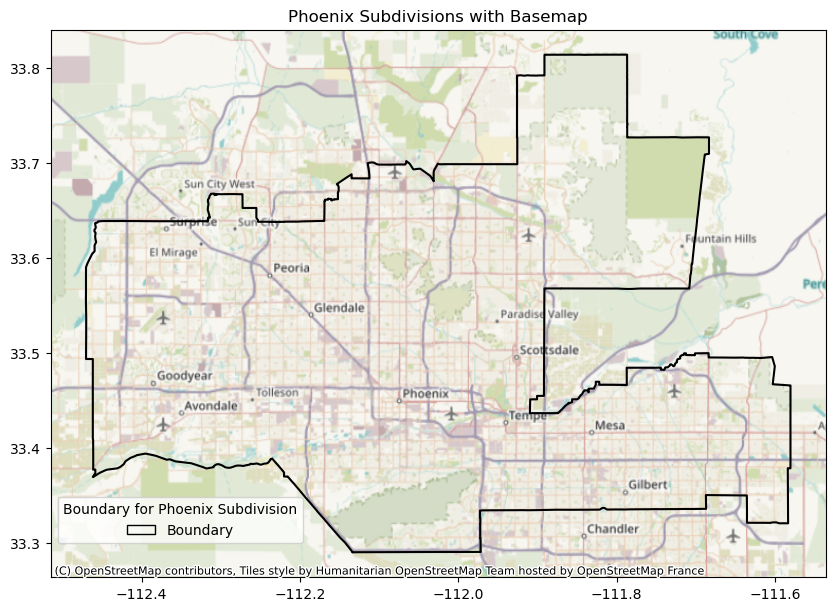

In [15]:
# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
arizona.boundary.plot(ax=ax, alpha=1, edgecolor='k')

# Add the basemap
ryan.add_basemap(ax, crs=arizona.crs)

# Custom Legend 
boundary_line = mpatches.Rectangle((0,0), 1, 1, edgecolor = 'k', facecolor= 'none', label = 'Boundary')
legend = ax.legend(handles=[boundary_line], title='Boundary for Phoenix Subdivision', loc = 'lower left', bbox_to_anchor = (0, 0.05))

plt.title('Phoenix Subdivisions with Basemap')
plt.show()



#### Finding Change in BII

Clip raster to Phoneix subdivision. Then ensures that we are only looking at BII we are intereted in.

In [16]:
# Clip bounding box
BII_2017_clip = (BII_2017.rio.clip_box(*arizona.total_bounds)
                 .rio.clip(arizona.geometry))
BII_2020_clip = (BII_2020.rio.clip_box(*arizona.total_bounds)
                .rio.clip(arizona.geometry))

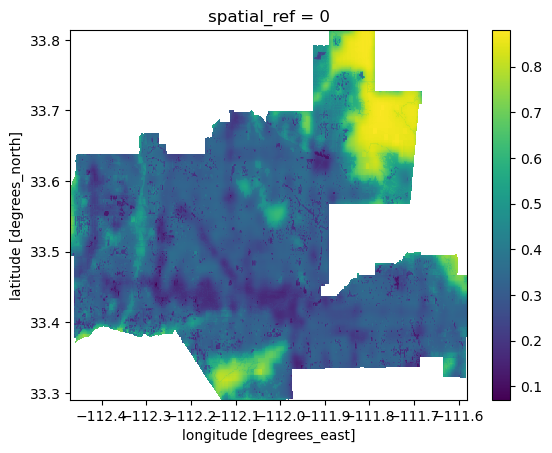

In [17]:
# Plot to check 
BII_2017_clip.plot()

Next, find area where BII is greater than .75 and fill the other values with 0. That way we only subtract the high BII areas. 

In [18]:
BII_2017_75 = BII_2017_clip >= 0.75
BII_2020_75 = BII_2020_clip >= 0.75

BII_2017_75 = BII_2017_75.fillna(0)
BII_2020_75 = BII_2020_75.fillna(0)

BII_diff = BII_2017_75.astype('int') - BII_2020_75.astype('int')

BII_diff = BII_diff.where(BII_diff == 1)

Then plot the new variable BII_diff. This is the .75 BII or greater areas that were lost in 2020.

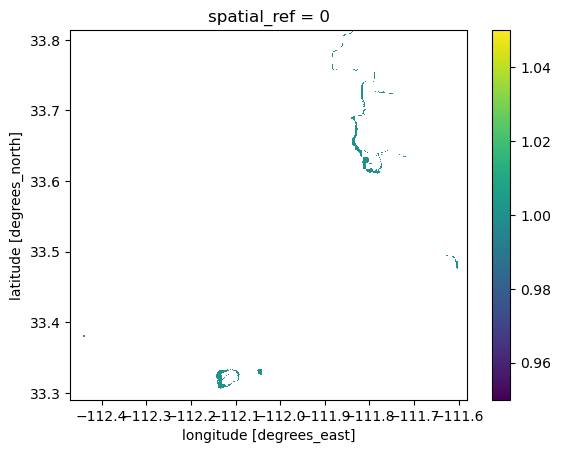

In [19]:
BII_diff.plot()

Now that we have a visual idea of the area lost, let's calculate the high BII area lost from 2017 to 2020. i.e area that has a BII of .75 or higher. 

Use a function to calculate the total area BII >= .75 for each year

In [20]:
# Number of pixels per unique BII value
# Create data frame for 2020
pix_counts_20 = (pd.DataFrame(np.unique(BII_2020_clip, return_counts=True))
                   .transpose()
                   .rename(columns={0: 'bii_value', 1: 'pix_count'})
                )
pix_counts_20

# Now for 2017
pix_counts_17 = (pd.DataFrame(np.unique(BII_2017_clip, return_counts=True))
                   .transpose()
                   .rename(columns={0: 'bii_value', 1: 'pix_count'})
                )
pix_counts_17

# Total number of pixels in the clipped raster
total_pixels_20 = pix_counts_20[pix_counts_20['bii_value'] >= 0].pix_count.sum()
# Return the number of pixels that contain bii >= 0.75
bii_pixels_20 = pix_counts_20[pix_counts_20['bii_value'] >= 0.75].pix_count.sum()

# Total number of pixels in the clipped raster
total_pixels_17 = pix_counts_17[pix_counts_17['bii_value'] >= 0].pix_count.sum()
# Return the number of pixels that contain bii >= 0.75
bii_pixels_17 = pix_counts_17[pix_counts_17['bii_value'] >= 0.75].pix_count.sum()


print(f"Percentage of Phoenix subdivision area with BII >= 0.75 in 2017: {(bii_pixels_17/total_pixels_17 * 100):.2f}%")
print(f"Percentage of Phoenix subdivision area with BII >= 0.75 in 2020: {(bii_pixels_20/total_pixels_20 * 100):.2f}%")

Percentage of Phoenix subdivision area with BII >= 0.75 in 2017: 7.13%
Percentage of Phoenix subdivision area with BII >= 0.75 in 2020: 6.49%


Plot it with the BII raster in 2017 to visualize how much was lost 

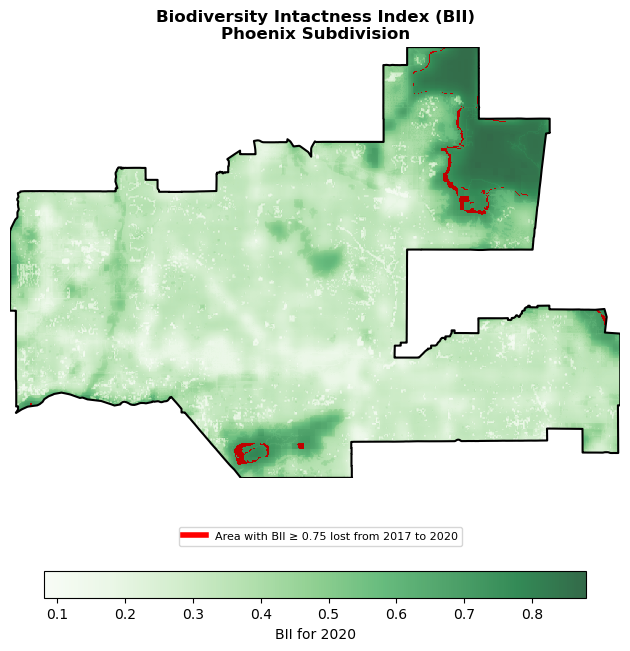

In [21]:
fig, ax = plt.subplots(figsize=(10, 8)) # Establish figure 


BII_2020_clip.plot(ax=ax, 
             cmap='Greens', 
             alpha=0.8,
             cbar_kwargs={'orientation': 'horizontal', # Plot BII 2020 raster
                         'label': 'BII for 2020',
                         'shrink': .7})

arizona.boundary.plot(ax=ax, 
                      color = 'black') # Plot Phoenix Subdivision boundary

BII_diff.plot(ax=ax, 
          cmap = 'gist_heat', 
          linewidths=0.5, add_colorbar = False) # Plot difference in BII raster

red_patch = mlines.Line2D([], [], 
                          color='red', 
                          label='Area with BII ≥ 0.75 lost from 2017 to 2020',  # Add red patch for legend
                          linewidth=4)

ax.legend(handles=[red_patch], 
          bbox_to_anchor = (0, -.1, 0.75, 0), # Add legend
          fontsize=8)

ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision', fontweight = 'bold') # Add title
ax.axis('off')
plt.show()

#### Results

The plot depicts the 2020 BII percentage for Phoenix Subdivision in green. The higher the percentage, the more biodiversity. The red area shows the BII area with a >= .75 (i.e 75%) that has been lost from 2017. 
